<h1><center>PROYECTO DE ANALISIS DE FOURIER</center></h1>
<h1><center>MULTIFRECUENCIA DE DOBLE TONO (DTMF)</center></h1>

<i><center>Procesamiento Digital de Señales</center></i>
<i><center>Juan David Rendon Berrio</center></i>
<i><center>Facultad de Ingenieria</center></i>
<i><center>Universidad de Antioquia</center></i>

In [34]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Circle, Wedge, Polygon
from IPython.display import display, HTML

from IPython.display import Audio
from PyDynamic.identification.fit_filter import LSIIR
from scipy.io import wavfile
from scipy import signal, fftpack
import control
import cmath
import sympy

|Frequencias | 1209Hz |  1336 Hz | 1477 Hz | 1633Hz|
|:--:|:--:|:--:|:--:|:--:|
**697Hz** | 1 | 2 | 3 |A|
**770Hz** | 4 | 5 | 6 |B|
**852Hz** | 7 | 8 | 9 |C|
**941Hz** | * | 0 | # |D|

In [35]:
## FUNCIONES DE CONFIGURACIÓN Y UTILIDADES
fs = 8_000 # Frecuencia de muestreo
number = "5201500055" # Número de teléfono DTMF a generar.

# Diccionario que mapea cada dígito a sus frecuencias correspondientes.
DTFM = {"1" : (697, 1209), "2" : (697, 1336), "3" : (697, 1477),
        "4" : (770, 1209), "5" : (770, 1336), "6" : (770, 1477),
        "7" : (852, 1209), "8" : (852, 1336), "9" : (852, 1477),
        "0" : (941, 1336)}

# Diccionario inverso de DTFM.
DTFM_inv = {v : k for k, v in DTFM.items()}

m = 0.5 #longitud de cada tono
s = 0.1 #espacio entre tonos
n = np.arange(0, m, 1/fs)
space = np.zeros(int(s * fs))

#Esta función toma una señal x y realiza una Transformada Rápida de Fourier (FFT) para obtener el espectro de frecuencia.
# La función devuelve las frecuencias f y los coeficientes de Fourier normalizados X.
def calculate_fft(x):
    ## Calcular DFT (utilizando el algoritmo FFT)
    N = 2000                        # número de muestras DFT
    x = signal.resample(x, N)   
    f = fftpack.fftfreq(N) * (2*N)  # Frecuencias naturales
    X = 1/N * fftpack.fft(x)        # Coeficientes de Fourier (divididos por N)
    return f, X

# Toma los valores de retorno de la funcion anterior y genera un gráfico de barras para visualizar el espectro de frecuencia.
# usando las librerias matplotlib y seaborn para el trazado.

def plot_fft(X, f):
    # Configuración
    # Asegúrate de que colors tenga suficientes elementos
    colors = sns.color_palette('Reds', n_colors=len(X))
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    for idx in range(len(X)):
        Xi = X[idx]
        markers, stems, _ = ax.stem(f, np.abs(Xi), label=r"Amplitud (DFT) $X_{}[k]$".format(idx))
        
        # Asegúrate de que idx esté dentro del rango de colors
        color_idx = idx % len(colors)
        plt.setp(markers, 'markerfacecolor', colors[color_idx])

    ax.set_title(r"Espectro de magnitud DFT $|X(k)|$", size=16, style='italic')
    ax.set_xlabel('Frecuencia en Hercios [Hz]')
    ax.set_ylabel('Magnitud en el dominio de frecuencia (espectro)')
    ax.grid(True, color='gray', alpha=0.5)
    ax.legend(fancybox=True)
    plt.show()

# Esta función toma una señal x y detecta los tonos DTMF presentes en ella.
def split_dtmf(x, win = 240, th = 200):
    '''
    Argumentos: x : La señal
             win: tamaño de la ventana, por defecto es 240
              th: El umbral predeterminado es 200.
    Retorno:
           tones: Una lista de tuplas con índices de inicio y finalización de cada tono.
    '''
    tones = []
    w = np.reshape(x[:int(len(x)/win)*win], (-1, win))
    w_e = np.sum(w*w, axis = 1)
    L = len(w_e)

    idx = 0
    while idx < L:
        while idx < L and w_e[idx] < th:
            idx = idx + 1
        if idx >= L:
            break
        i = idx
        while i < L and w_e[i] > th:
            i = i + 1
        tones.append((idx * win, i * win))
        idx = i
    return tones

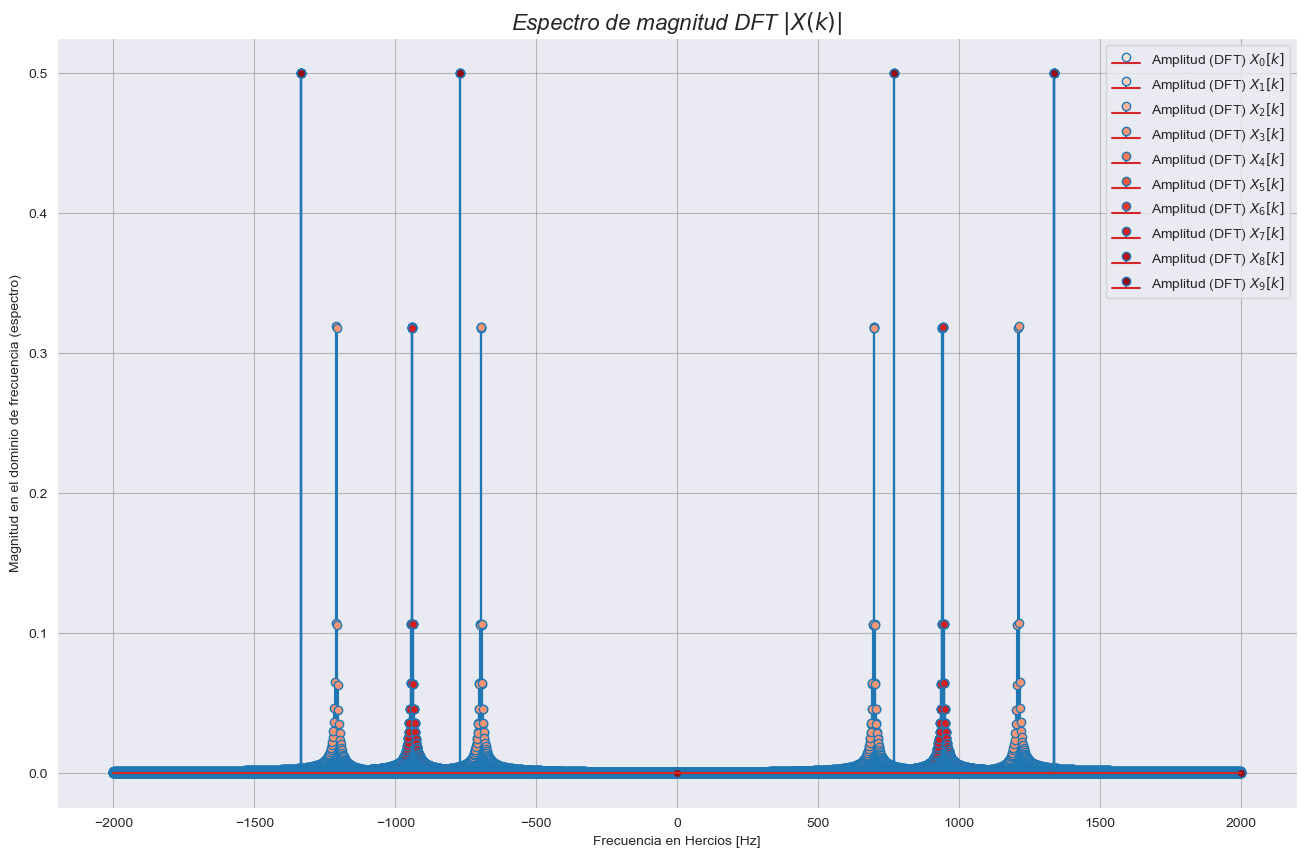

In [36]:
# Esta funcion lo que hace es construir señales DTMF (Multifrecuencia de doble tono) 
# correspondientes a un número de teléfono dado.

def create_my_number(number):
    # 'x' contiene la señal DTMF final que se está construyendo.
    # 'X' contiene una lista con los resultados de las DFT de cada tono DTMF.
    
    x, X = np.array([]), []
    for num in list(number):
        # Se obtienen las frecuencias correspondientes al dígito actual.
        f1, f2 = DTFM[num]
        # paso 1 [DOMINIO DEL TIEMPO]: [0,5 segundos: muestras, 0,1 segundos: intervalo o muestras/5]
        xi = np.cos(2*np.pi*f1*n) + np.cos(2*np.pi*f2*n)
        x = np.concatenate((x, xi, space))
        # paso 2 [DOMINIO DE FRECUENCIA]: Calcule 10 DFT de los dígitos respectivos
        f, Xi   = calculate_fft(xi)
        X.append(Xi)

    # Paso 3 [DOMINIO DE FRECUENCIA]: Grafica las DTFT
    plot_fft(X, f)
    return x

x = create_my_number(number)

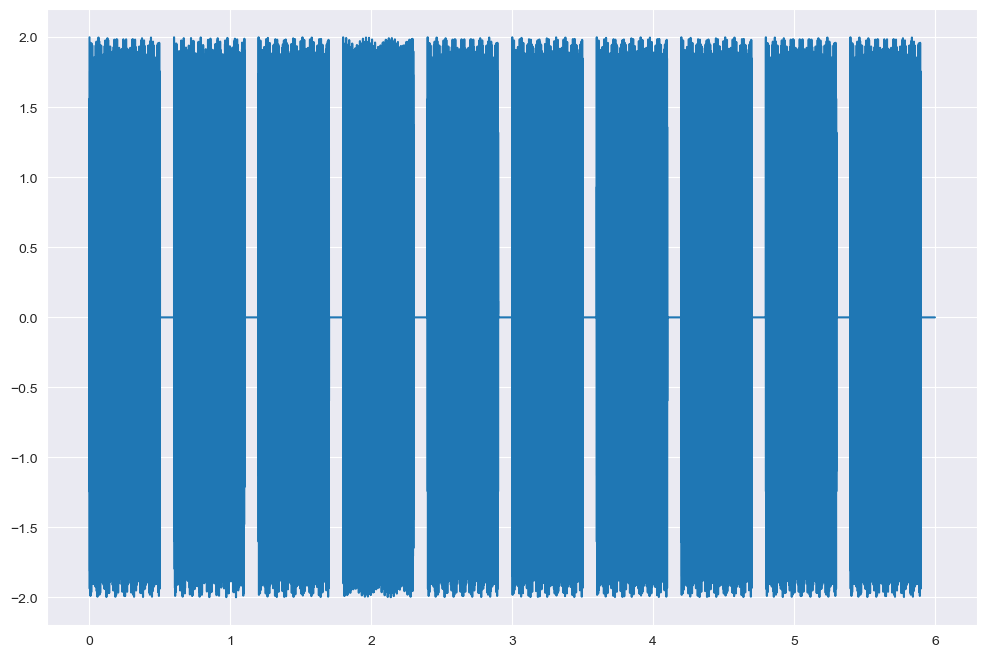

In [37]:
## REPRODUCIR EL AUDIO
display(Audio(x, rate = fs))
fig, ax = plt.subplots(figsize = (12,8))
# Apariencia de la señal de audio generada
plt.plot(np.arange(0, len(x)/fs, 1/fs), x)

# **PARTE 2 - CONSTRUIR UN FILTRO FIR**

Creamos un filtro FIR que filtre los siguientes dígitos (y sus respectivas frecuencias)

| |$f_1$ | $f_2$ | 
|:-:|:-:|:-:|
**7** | 852 | 1209|
**8** | 852 | 1336|
**9** | 852 | 1477 | 
**0** | 941 | 1336| 

* En nuestro caso necesitamos un **filtro de parada de banda**. Haremos una implementación sencilla. Entonces nuestra entrada es la señal de 5,9 segundos (10 dígitos) $x$. El filtro de banda de paso **detendremos** las bandas de frecuencia [800,100], por lo que los dígitos [7,8,9,*, 0, #] quedarán con solo **1** frecuencia, en lugar de la ** inicial 2** que son necesarios para reconocer el dígito. Por lo tanto, ¡cualquier función de decodificación (parte 4) no reconocería estos dígitos!
  * $f_{Corte bajo} = 800Hz$
  * $f_{Corte alto} = 1000Hz$
  * $orden = 5$, pero podríamos usar más para una mayor precisión (pero con más esfuerzo computacional)

In [38]:
#  Se crea un filtro FIR en función de los parámetros especificados
# Frecuencia de muestreo, Frecuencias de corte para el filtro, 
# Dependiendo de kind, se especifica la frecuencia de corte baja, alta o la banda de parada
from pylab import *
import scipy.signal as signal

def butter(fs, lowcut = 0.0, highcut = 0.0, kind = 'bandstop', order = 5):
    f_nyq = fs / 2
    low = lowcut / f_nyq
    high = highcut / f_nyq
    if kind == "low" : 
        b, a = signal.butter(order, low, btype = kind)
    elif kind == "high" : 
        b, a = signal.butter(order, high, btype = kind)
    else:
        b, a = signal.butter(order, [low, high], btype = kind)
    return b, a

# Esta función grafica las señales de entrada (x) y de salida filtrada (y) en el dominio del tiempo.
def plot_time_domain(signals):
    x, y = signals
    n = np.arange(0, len(x)/fs, 1/fs)
    
    fig, ax = plt.subplots(figsize = (10,8))
    sns.set_style("darkgrid")
    ax.set_title(r"Señal de salida $y[n] = h_{FIR}[n] * x[n]$", size = 16, style = 'italic')
    ax.legend(fancybox = True)
    ax.set_xlabel('tiempo (sec)', fontsize = 16)
    ax.set_ylabel('Amplitud', fontsize = 16)
    ax.plot(n, x, 'r.-', linewidth = 1,  label = r"Señal de entrada $x[n]$" )
    ax.plot(n, y, 'b.-', linewidth = 1,  label = r"Señal filtrada $y[n]$" )
    ax.grid(True, color = 'gray', alpha=0.5)
    ax.legend(fancybox=True)
    
    plt.show()

#Esta función realiza un análisis de frecuencia de las señales de entrada (x) 
# y de salida filtrada (y) y visualiza sus espectros de magnitud en comparación con el filtro de parada de banda (H[k]).
# Tupla que contiene las señales de entrada y salida.
# Coeficientes del filtro (w y h).

def plot_freq_domain(signals, filter):
    # Paso 1: divida x, y en tonos distintos y calcule DFT X[k], Y[k]
    X, Y = [], []
    x, y = signals
    
    for idx in split_dtmf(x):
        xi = x[idx[0] : idx[1]]
        f, Xi = calculate_fft(xi)
        X.append(Xi)
    
    for idx in split_dtmf(y):
        yi = y[idx[0] : idx[1]]
        f, Yi = calculate_fft(yi)
        Y.append(Yi)
  
    # Paso 2: recuperar el filtro de exclusión de banda H[k]
    w, h = filter
    
    # Paso 3: visualizar
    fig, ax = plt.subplots(figsize = (14,10))
    sns.set_style("darkgrid")
    ax.set_title(r"Espectro de salida  $Y[k] = H_{FIR}[k] \cdot X[k]$", size = 16, style = 'italic')
    ax.plot((fs * 0.5 / np.pi) * w, abs(h), label = "Filtro de parada de banda $H[k]$".format(f))
    
    for idx in range(len(X)) :
        Xi = X[idx] 
        N = len(Xi)
        label = r"Amplitud (DFT) $X[k]$" if idx == 0 else "_nolegend_"
        ax.stem(f[ : N//2], np.abs(Xi[ : N//2 ]), linefmt = '-b',  markerfmt = 'bo', label = label)
        
    for idx in range(len(Y)):
        Yi = Y[idx] 
        N = len(Yi)
        label = r"Amplitud (DFT) $Y[k]$" if idx == 0 else "_nolegend_"
        ax.stem(f[ : N//2], np.abs(Yi[ : N//2 ]), linefmt = '-r',  markerfmt = 'ro', label = label)

    ax.set_title(r"Espectro de magnitud DFT $|X(k)|$ ", size = 16, style = 'italic')
    ax.set_xlabel('Frecuencia en Hercios [Hz]')
    ax.set_ylabel('Magnitud en el dominio de frecuencia (espectro)')
    ax.grid(True, color = 'gray', alpha = 0.5)
    ax.legend(fancybox = True)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


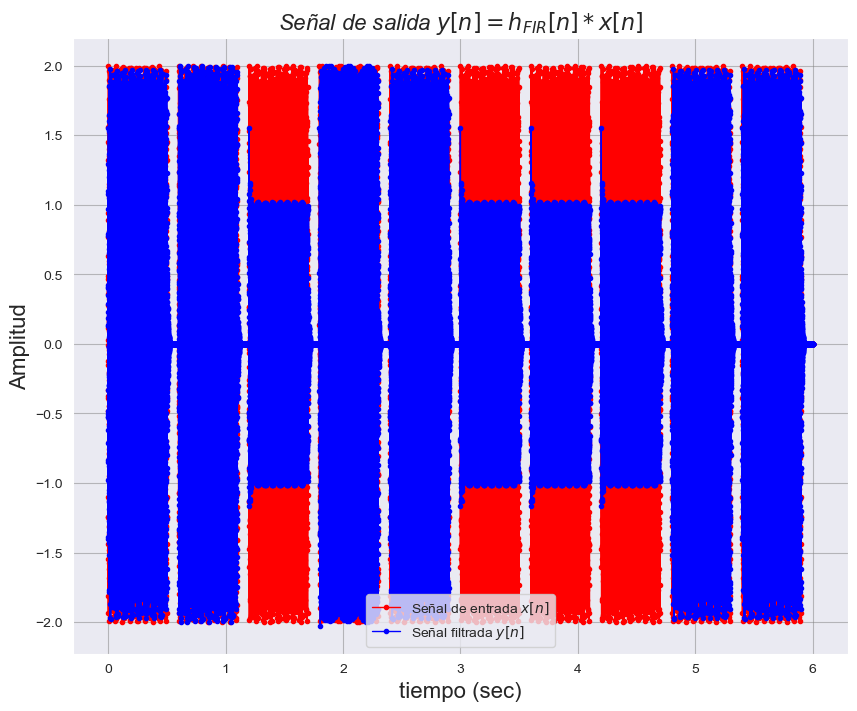

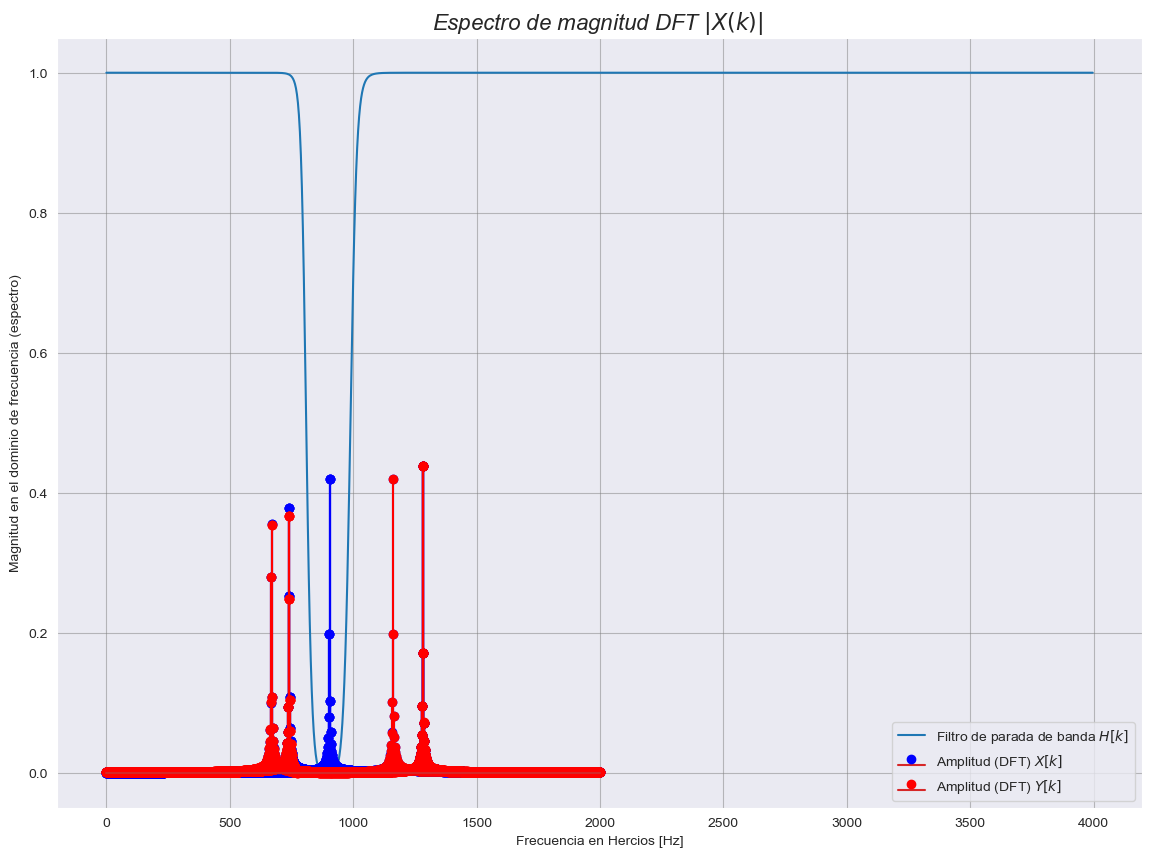

In [39]:
def filter_my_number(x) : 
    ## Paso 1: diseño del filtro h[n]
    fs = 8000.0
    order = 5
    lowcut  = 800
    highcut = 1000
    b, a = butter(fs, lowcut, highcut, 'bandstop', order)
    w, h = signal.freqz(b, a, worN = 1000)
    
    ## Paso 2: aplicación del filtro y[n] = x[n] * h[n]
    y = signal.lfilter(b, a, x)
    display(Audio(x, rate = fs))
    display(Audio(y, rate = fs))
    
    ## Paso 3: [DOMINIO DEL TIEMPO] Grafica de los resultados
    plot_time_domain(signals = [x, y])
    
    ## paso 4: [DOMINIO DE FRECUENCIA] Grafica de los resultados
    plot_freq_domain(signals = [x, y], filter = [w,h])

filter_my_number(x)

# **PARTE 3 - CONSTRUCCION DE FILTRO PARA CONTAR CEROS**

* Una forma eficaz de determinar un tono es crear un banco de filtros como se muestra a continuación. En esta figura, a modo de ejemplo, se muestra una señal "0" ingresando al banco de filtros. Tenga en cuenta que los filtros de paso de banda (BPF) asociados con los tonos de 941 Hz y 1336 Hz proporcionan las salidas más grandes.
 * **FILTRO DE PASO BAJO** : $f_{corte} = 941 + \frac{1204 - 941}{2} = 1075 Hz$, usamos un $orden = 30$, para reducir mucho el ancho de transición que afectaría las frecuencias cercanas a $f$.
  * **FILTRO DE PASO ALTO** : $f_{corte} = 1204 - \frac{1204 - 941}{2} = 1075 Hz$. Usamos un $orden = 30$
  * **FILTROS BANPASS**: Sea $f$ la frecuencia (central) del filtro, luego $f_{corte-bajo} = f - 25Hz, f_{corte-alto} = f + 25Hz$ alrededor de la frecuencia. Entonces, podemos lograr una banda estrecha con solo $pedido = 5$. ¡Esta experimentación con diferentes órdenes es crucial para reducir el costo computacional!

In [40]:
## FUNCIONES DE UTILIDAD

# La función se utiliza para visualizar la respuesta en frecuencia de varios filtros en la misma figura, 
# facilitando la comparación y análisis de los diferentes filtros.

def plot_filters(filters, lowhigh = False) : 
    fig, ax = plt.subplots(figsize = (12,8))
    plt.clf()
    if lowhigh : 
        plt.plot((fs * 0.5 / np.pi) * filters[0][2], abs(filters[0][3]),
                 label = "Filtro de paso bajo f = {}Hz".format(filters[0][4]))
        plt.plot((fs * 0.5 / np.pi) * filters[1][2], abs(filters[1][3]),
                 label = "Filtro de paso alto f = {}Hz".format(filters[0][4]))
    for f in filters[2:] : 
        plt.plot((fs * 0.5 / np.pi) * f[2], abs(f[3]), label = "filtro pasa banda f = {}Hz".format(f[4]))
        #  tazado de una línea punteada que representa la raíz cuadrada de 0.5 
        #(equivalente a -3 dB, un punto común de referencia en el diseño de filtros).
        plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Ganancia')
        plt.grid(True)
        plt.legend(loc = 'best')

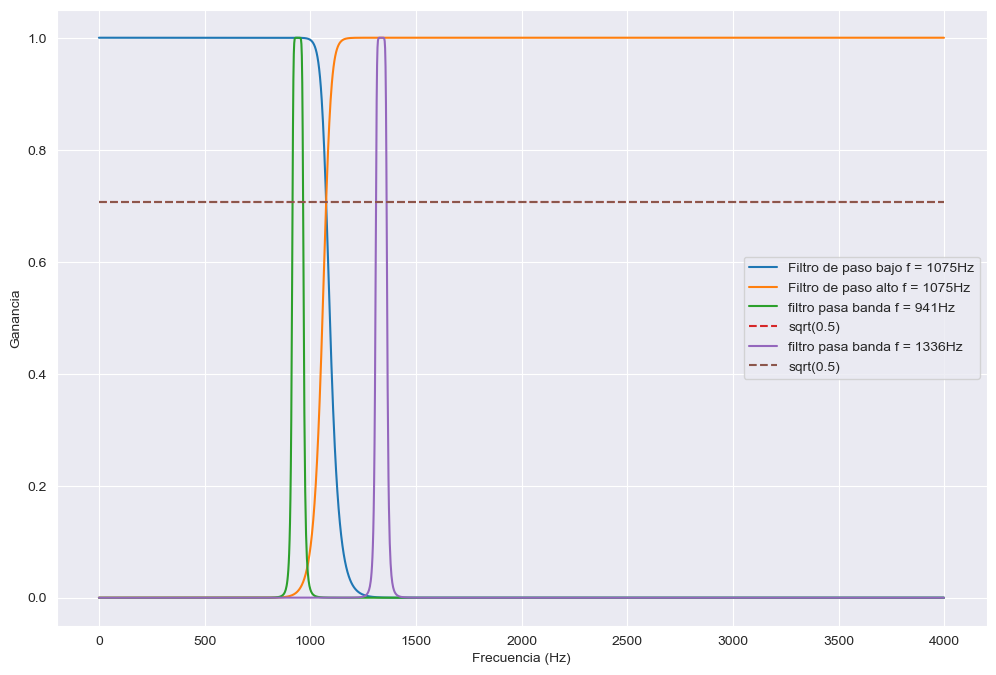

In [41]:
## [2 FILTROS DE PASO BAJO + PASO ALTO]
b, a = butter(fs, lowcut = 1075, kind = "low", order = 30)
w, h = signal.freqz(b, a, worN = 2000)
filter_lp = [b, a, w, h, 1075] 

b, a = butter(fs, highcut = 1075, kind = "high", order = 30)
w, h = signal.freqz(b, a, worN = 2000)
filter_hp = [b, a, w, h, 1075] 

## [7 FILTROS PASA BANDA ] (uno para cada frecuencia)
# Se crea un diccionario filters_bp para almacenar filtros pasa banda, 
# cada uno asociado con una frecuencia DTMF específica.
filters_bp = {697 : [] , 770 : [] , 852 : [] , 941 : [] ,
              1209 : [] , 1336 : [] , 1477 : [] }

#Se utiliza un bucle for para iterar sobre las frecuencias DTMF y diseñar un filtro pasa banda para cada una.
# 
for f, v in filters_bp.items():
    f_l  = f - 25
    f_h = f + 25
    # Para cada frecuencia DTMF, se ajustan las frecuencias de corte 
    #(f_l y f_h) para crear un rango de ±25 Hz alrededor de la frecuencia DTMF.
    b, a = butter(fs, lowcut = f_l , highcut = f_h, kind = "bandpass")
    w, h = signal.freqz(b, a, worN = 2000)
    filters_bp[f] = [b, a, w, h, f]

# se visualiza las respuestas en frecuencia de los filtros diseñados.
# El parámetro lowhigh=True indica que se deben trazar también los filtros de paso bajo y paso alto.
plot_filters([filter_lp, filter_hp, filters_bp[941], filters_bp[1336]], lowhigh = True)

El no. de ceros en el numero - 5201500055 : 4


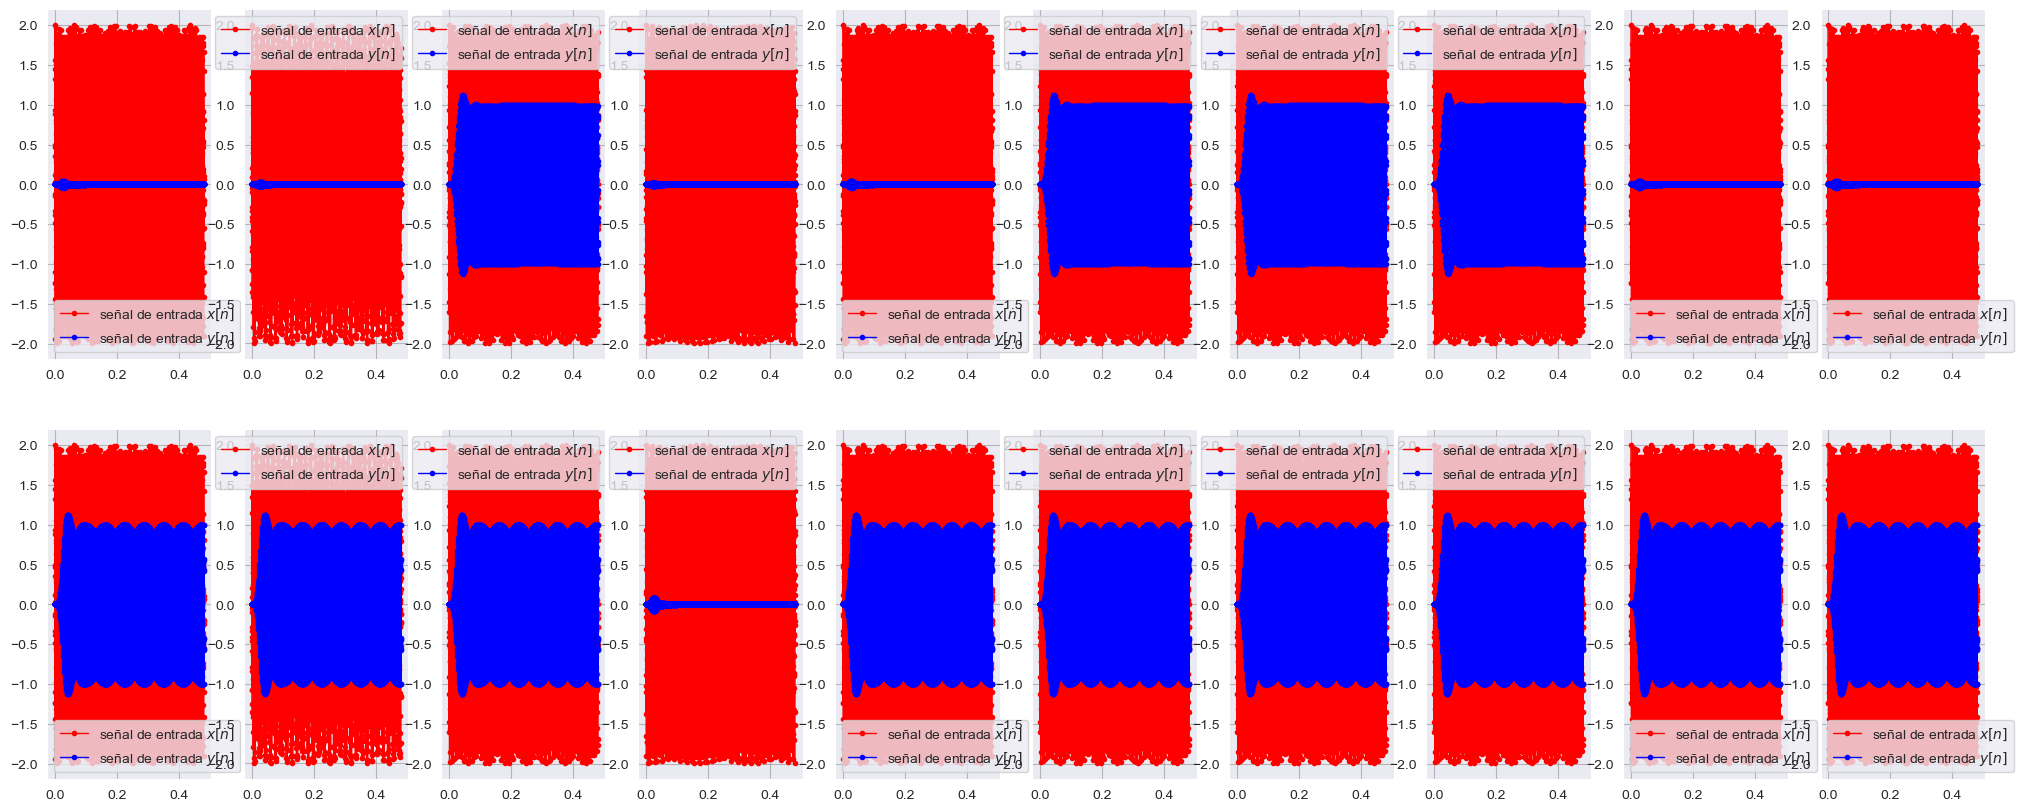

In [42]:
# cuenta el número de dígitos "0" presentes en una secuencia de tonos DTMF.

def count_my_zeros(x) :
    # Se crea una figura con dos filas de subgráficos (axs) para visualizar las señales de entrada y salida de cada tono.
    fig, axs = plt.subplots(nrows = 2, ncols = 10, figsize = (25,10))
    sns.set_style("darkgrid")
    zeros = 0                    # contador de ceros
    th = 0.3                     # Umbral para determinar si una frecuencia está presente en un tono.
    i = 0                        # Variable de índice para controlar la ubicación en los subgráficos.
    
    # Se utiliza la función split_dtmf para obtener los índices de inicio y finalización de cada tono en la señal.
    
    ## Paso 1: divide la señal en tonos.
    for idx in split_dtmf(x):
        xi = x[idx[0] : idx[1]]
        n = np.arange(0, len(xi)/fs, 1/fs)

        ## paso 1.1: comprobar si f = 941 Hz está presente en este tono
        b, a, _, _, _ = filter_lp
        yi = signal.lfilter(b, a, xi)
        b, a, _, _, _ = filters_bp[941]
        yi = signal.lfilter(b, a, yi)
        low = 1 if max(yi) > th else 0

        ## paso 1.2: visualizar
        axs[0,i].plot(n, xi,'r.-', linewidth = 1,  label = r"señal de entrada $x[n]$" )
        axs[0,i].plot(n, yi,'b.-', linewidth = 1,  label = r"señal de entrada $y[n]$" )
        axs[0,i].legend(fancybox = True)
        axs[0,i].grid(True, color = 'gray', alpha=0.5)

        ## paso 1.3: compruebe si f = 1336 Hz está presente en este tono
        b, a, _, _, _ = filter_hp
        yi = signal.lfilter(b, a, xi)
        b, a, _, _, _ = filters_bp[1336]
        yi = signal.lfilter(b, a, yi)
        high = 1 if max(yi) > th else 0

        ## paso 1.4: visualizar
        axs[1,i].plot(n, xi,'r.-', linewidth = 1,  label = r"señal de entrada $x[n]$" )
        axs[1,i].plot(n, yi,'b.-', linewidth = 1,  label = r"señal de entrada $y[n]$" )
        axs[1,i].legend(fancybox = True)
        axs[1,i].grid(True, color = 'gray', alpha=0.5)

        ## paso 1.5: encuentra si dígito = "0"
        if low and high : zeros += 1

        i += 1
    return zeros

zeros = count_my_zeros(x)
print("El no. de ceros en el numero - 5201500055 : {}".format(zeros))

* **POR QUÉ FUNCIONA**: En la visualización anterior podemos ver que para todos los dígitos "0" las señales filtradas ($lowpass \rightarrow bandpass[941]$), ($highpass \rightarrow bandpass[1336]$) tienen **ambos** supuesto valores distintos de cero. Entonces usamos 2 variables booleanas para determinar si ambas son distintas de cero, en ese caso incrementamos el contador del total "0" encontrado en la señal.

# **PARTE 4 - DECODIFICAR la señal DTMF**

* No se toma una decisión de detección para cada muestra de la señal de entrada. En cambio, solo tomamos una decisión para cada  "ventana" de muestra. Esto hace que sea más probable que sólo se tome una decisión en las proximidades del cruce del umbral. También reduce un poco el tiempo de cálculo. Podemos elegir un número menor, pero entonces aumentamos el riesgo del problema del cruce múltiple. Alternativamente, podemos hacerlo más grande; sin embargo, si lo hacemos demasiado grande, nuestro detector puede perder tonos cortos o silencios.

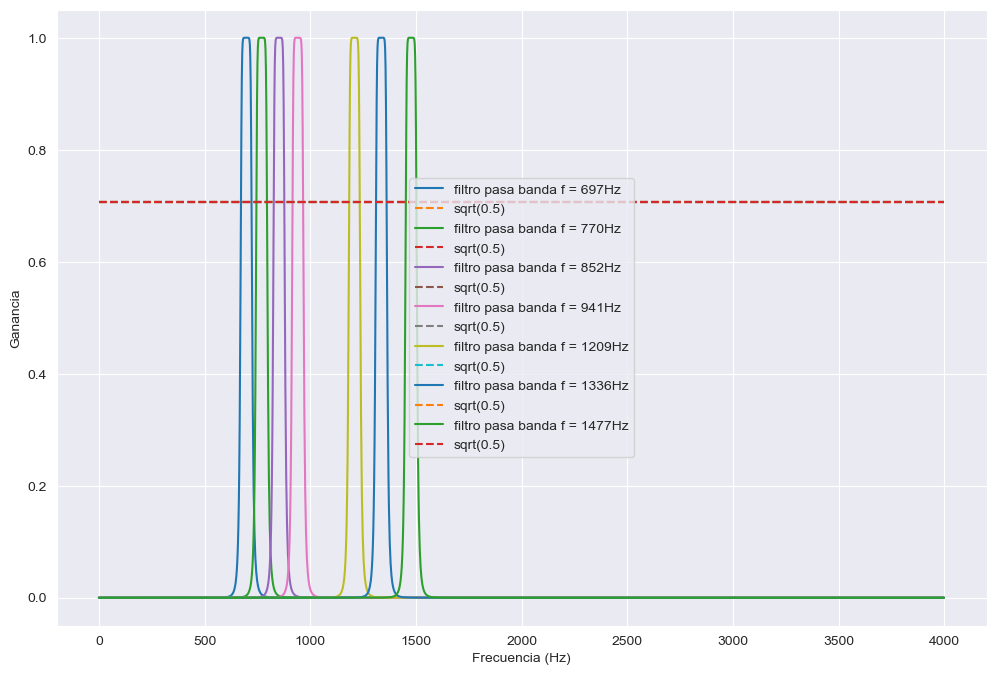

In [43]:
## GRAFICAR LOS FILTROS UTILIZADOS
filters = [[], []] +  list(filters_bp.values())
plot_filters(filters, lowhigh = False)

In [44]:
# decodificamos una señal DTMF (Tono Múltiple de Frecuencia Dual) y devolvemos el número correspondiente.
def decode_DTMF_signal(x):
  '''
  Argumento: x : la señal
  Retorna : numero
  '''
  number = ""
  th = 0.3
  ## paso 0: normalizar la señal
  x = x / np.max(np.abs(x),axis = 0)
  ## paso 1: divide la señal en tonos
  for idx in split_dtmf(x, win = 300, th = 0.2):
    xi = x[idx[0] : idx[1]]
    n = np.arange(0, len(xi)/fs, 1/fs)

    ## paso 1.2: encontrar baja frecuencia
    f_low = 0
    b, a, _, _, _ = filter_lp
    yi = signal.lfilter(b, a, xi)
    for f, filter in filters_bp.items() : 
      if f > 1000 : continue
      b, a, _, _, _ = filter
      yi_bp = signal.lfilter(b, a, yi)

      if max(yi_bp) > th : 
        f_low = f
        break
    
    ## paso 1.3: encontrar alta frecuencia
    f_high = 0
    b, a, _, _, _ = filter_hp
    yi = signal.lfilter(b, a, xi)

    for f, filter in filters_bp.items() : 
      if f < 1000 : continue
      b, a, _, _, _ = filter
      yi_bp = signal.lfilter(b, a, yi)
      if max(yi_bp) > th : 
        f_high = f
        break

    ## paso 1.4: recuperar dígito
    digit = DTFM_inv[(f_low ,f_high)]
    number += str(digit)
  return number

In [45]:
## CASO DE PRUEBA 1: señal inicial
num = decode_DTMF_signal(x)
print("El número decodificado es = {}".format(num))

## CASO DE PRUEBA 2: 'number_to_unveil.wav'
fs, x2 = wavfile.read('number_to_unveil.wav')
num = decode_DTMF_signal(x2)
print("El número decodificado es = {}".format(num))

## CASO DE PRUEBA 3: 'dtmfL1.wav'
fs, x3 = wavfile.read('dtmfL1.wav')
num = decode_DTMF_signal(x3)
print("El número decodificado es = {}".format(num))

El número decodificado es = 5201500055
El número decodificado es = 6943120587
El número decodificado es = 8548928


In [46]:
## NORMALIZAR, VISUALIZAR
x_norm  = x /  np.max(np.abs(x),axis = 0)
x2_norm  = x2 /  np.max(np.abs(x2),axis = 0)
x3_norm  = x3 /  np.max(np.abs(x3),axis = 0)

display(Audio(x, rate = fs))
display(Audio(x2, rate = fs))
display(Audio(x3, rate = fs))

Text(0.5, 1.0, 'señal de entrada $x3[n]$ (dtmfL1.wav)')

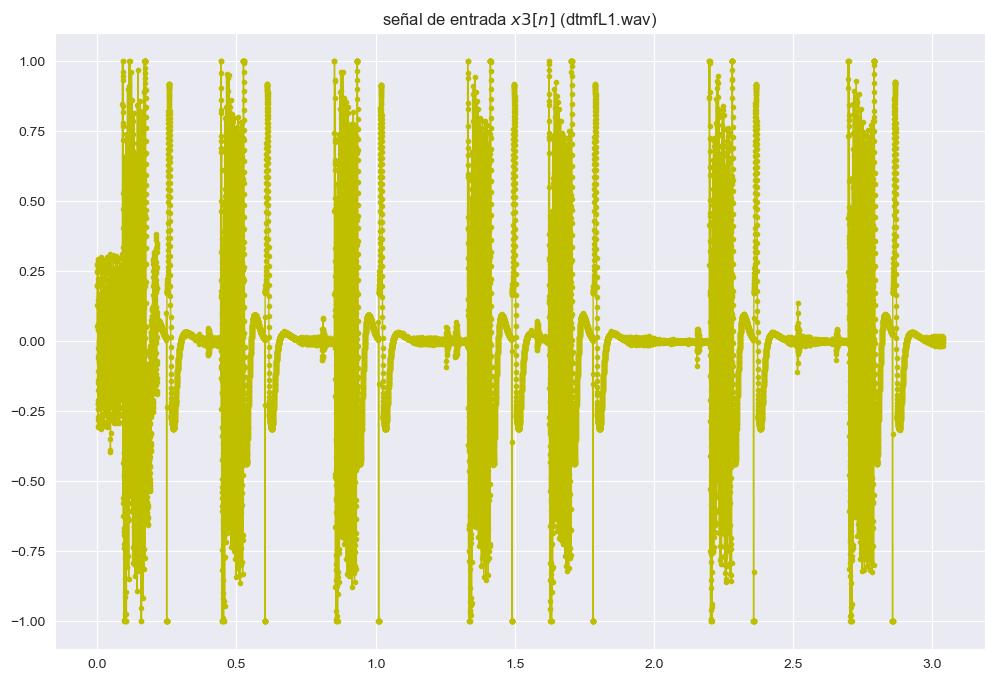

In [47]:
fig, ax = plt.subplots(figsize = (12,8))
n = np.arange(0, len(x3_norm)/fs, 1/fs)
ax.plot(n, x3_norm,'y.-', linewidth = 1,  label = r"señal de entrada $x3[n]$" )
ax.set_title(r"señal de entrada $x3[n]$ (dtmfL1.wav)")

Text(0.5, 1.0, 'señal de entrada $x2[n]$ (number_to_unveil.wav)')

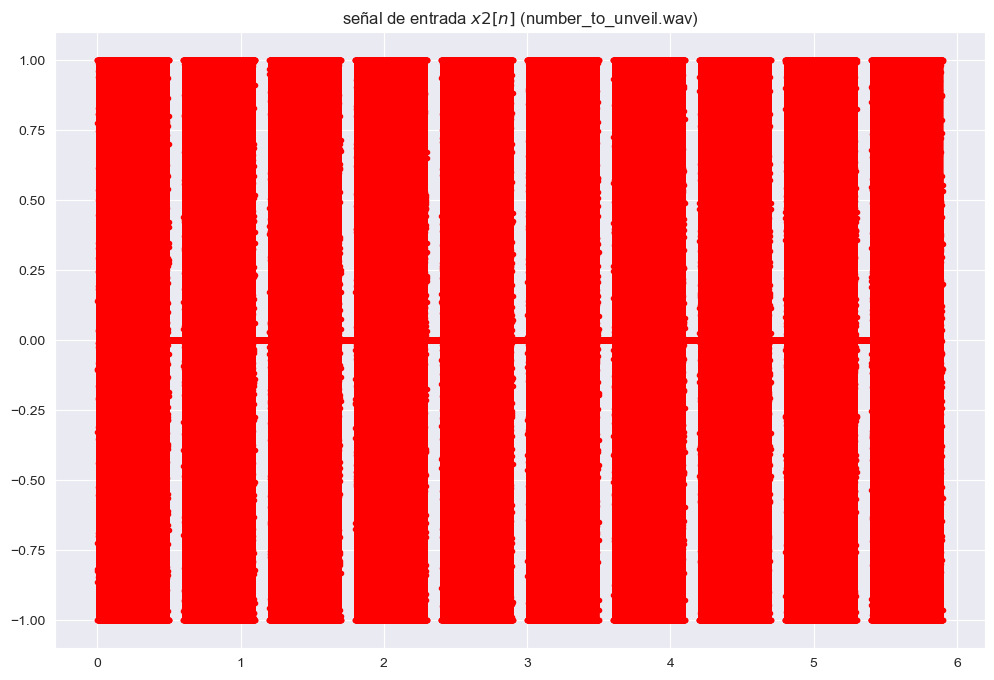

In [48]:
fig, ax = plt.subplots(figsize = (12,8))
n = np.arange(0, len(x2_norm)/fs, 1/fs)
ax.plot(n, x2_norm,'r.-', linewidth = 1,  label = r"señal de entrada $x2[n]$" )
ax.set_title(r"señal de entrada $x2[n]$ (number_to_unveil.wav)")

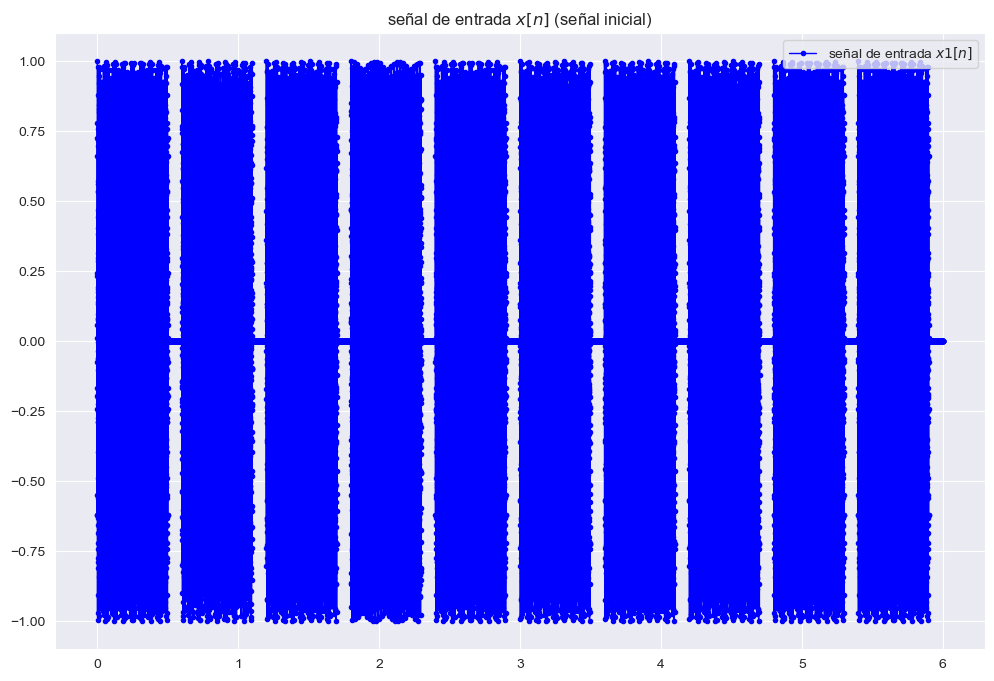

In [49]:
fig, ax = plt.subplots(figsize = (12,8))
n = np.arange(0, len(x_norm)/fs, 1/fs)
ax.plot(n, x_norm,'b.-', linewidth = 1,  label = r"señal de entrada $x1[n]$" )
ax.set_title(r"señal de entrada $x[n]$ (señal inicial)")
ax.legend()

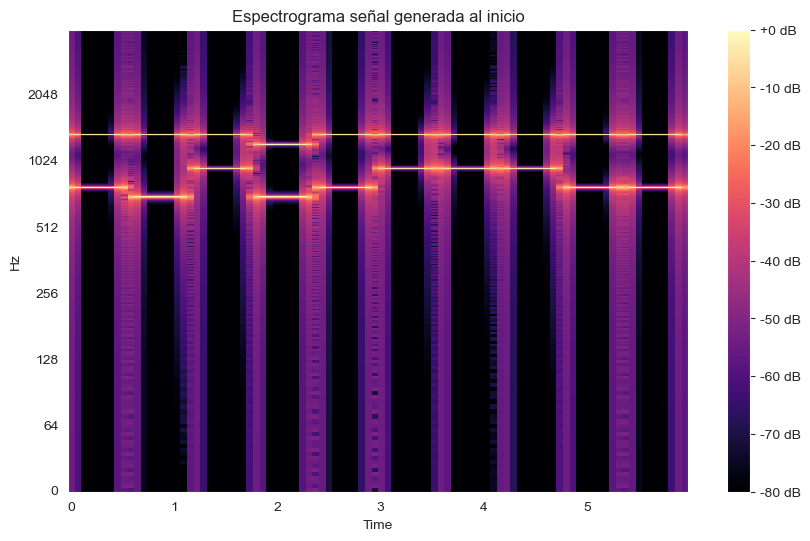

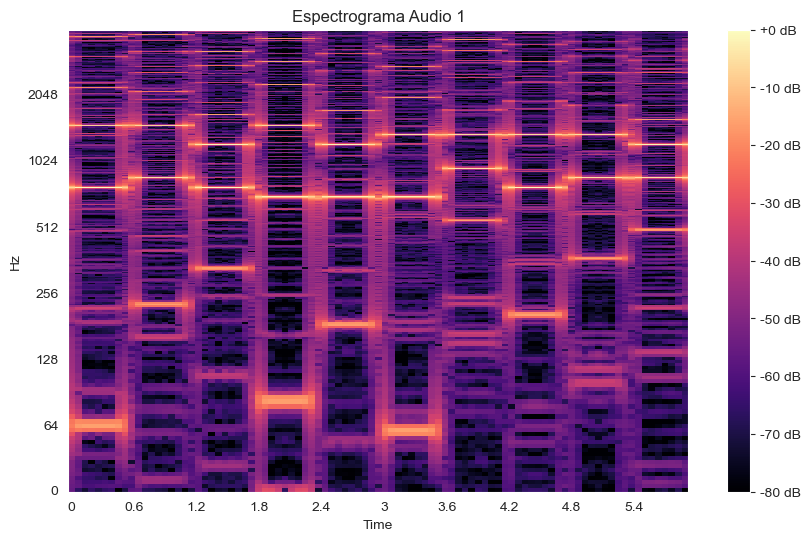

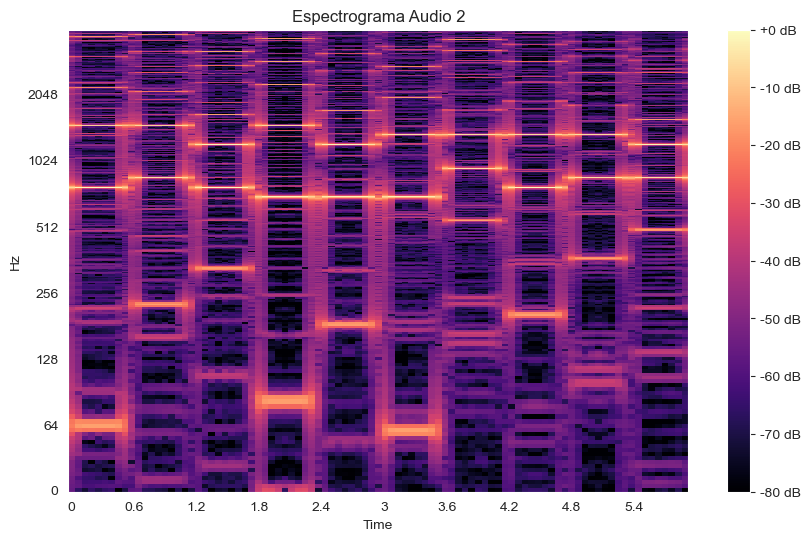

In [50]:
from scipy.io import wavfile
from scipy.signal import spectrogram
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Calcular el espectrograma utilizando librosa
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)

# Graficar el espectrograma
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma señal generada al inicio')
plt.show()

# Cargar el archivo de audio
audio_path = 'number_to_unveil.wav'
tono1, sr1 = librosa.load(audio_path, sr=None)

# Calcular el espectrograma utilizando librosa
D = librosa.amplitude_to_db(np.abs(librosa.stft(tono1)), ref=np.max)

# Graficar el espectrograma
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr1, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma Audio 1')
plt.show()

# Cargar el archivo de audio
audio_path = 'number_to_unveil.wav'
audio2, sr2 = librosa.load(audio_path, sr=None)

# Calcular el espectrograma utilizando librosa
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio2)), ref=np.max)

# Graficar el espectrograma
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma Audio 2')
plt.show()

* el espectrograma te brinda una representación visual de cómo la energía de la señal está distribuida en el dominio del tiempo y la frecuencia. Puedes identificar patrones, cambios y características específicas de la señal al observar las variaciones en color a lo largo de los ejes de tiempo y frecuencia.

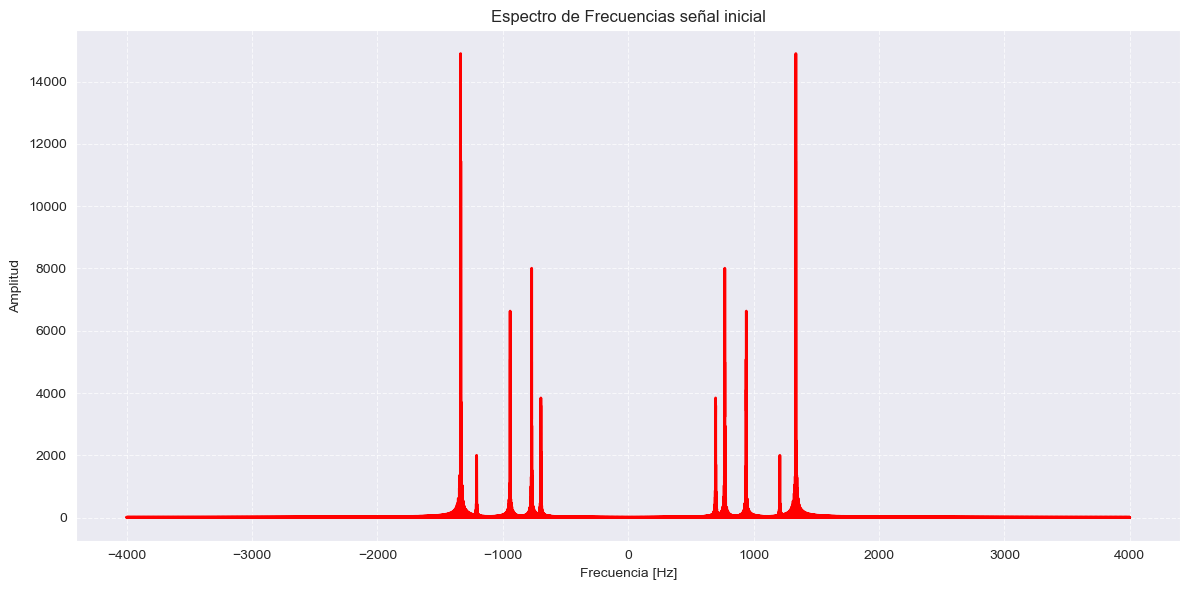

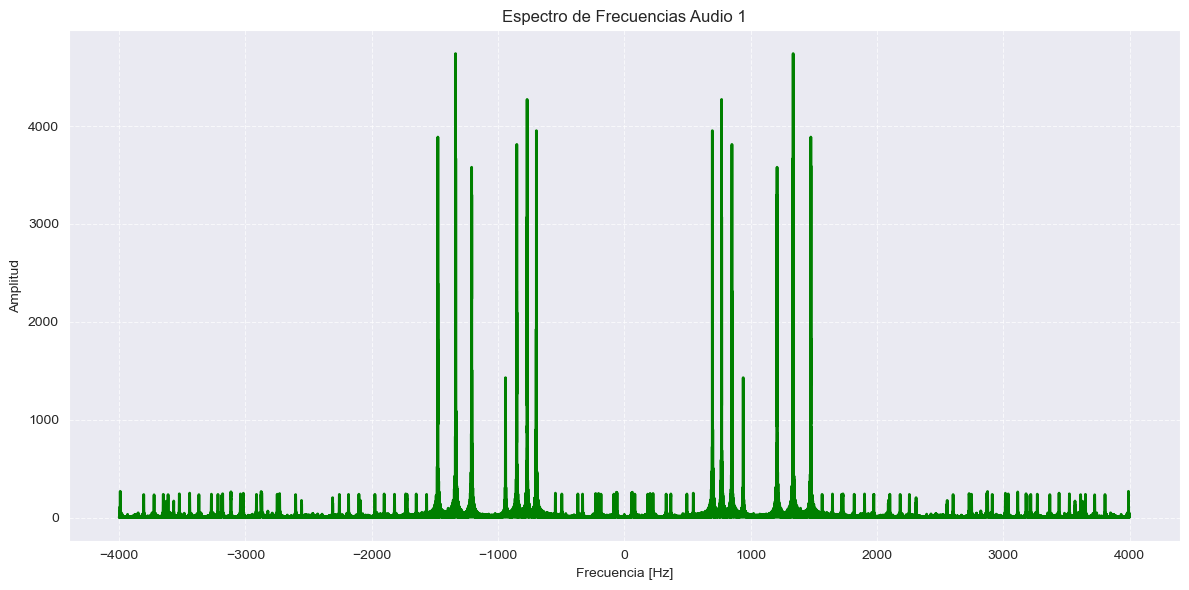

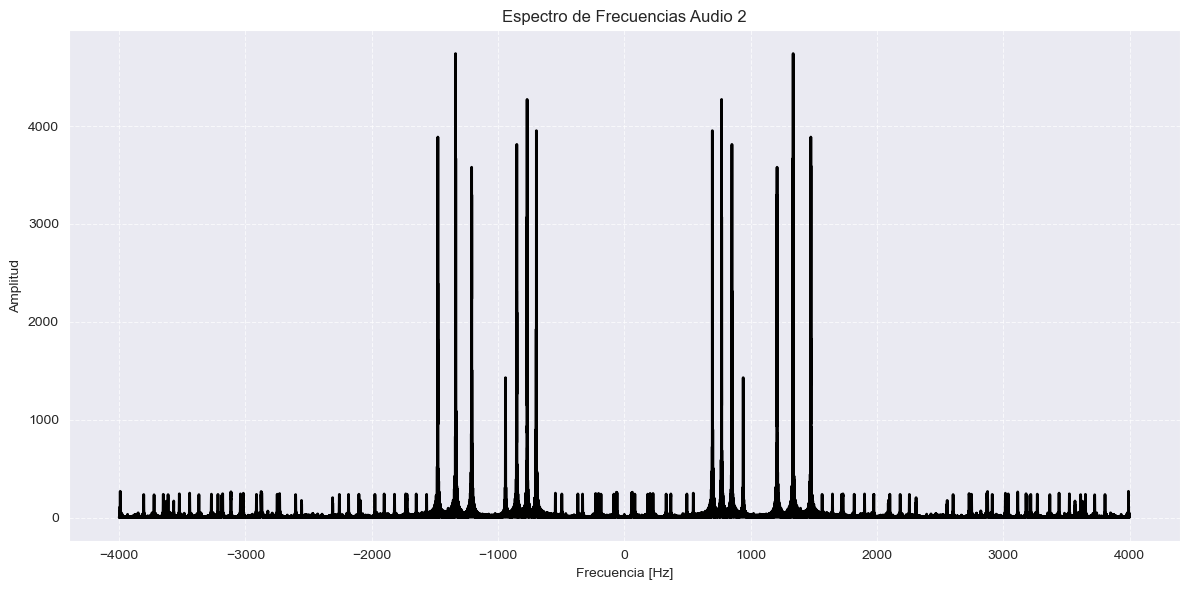

In [51]:
# Calcular la FFT
fft_result = np.fft.fft(x)
fft_freq = np.fft.fftfreq(len(x), 1/fs)

# Calcular la magnitud del espectro
magnitude = np.abs(fft_result)

# Graficar todo el espectro de frecuencias
plt.figure(figsize=(12, 6))
plt.plot(fft_freq, magnitude, color='red', linewidth=2)
plt.title('Espectro de Frecuencias señal inicial')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calcular la FFT
fft_result = np.fft.fft(tono1)
fft_freq = np.fft.fftfreq(len(tono1), 1/fs)

# Calcular la magnitud del espectro
magnitude = np.abs(fft_result)

# Graficar todo el espectro de frecuencias
plt.figure(figsize=(12, 6))
plt.plot(fft_freq, magnitude, color='green', linewidth=2)
plt.title('Espectro de Frecuencias Audio 1')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calcular la FFT
fft_result = np.fft.fft(audio2)
fft_freq = np.fft.fftfreq(len(audio2), 1/fs)

# Calcular la magnitud del espectro
magnitude = np.abs(fft_result)

# Graficar todo el espectro de frecuencias
plt.figure(figsize=(12, 6))
plt.plot(fft_freq, magnitude, color='black', linewidth=2)
plt.title('Espectro de Frecuencias Audio 2')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

* El análisis del espectro de frecuencias es esencial para comprender la composición espectral de una señal de audio, lo que puede ser crucial en diversas aplicaciones, como la música, el procesamiento del habla, la detección de eventos y el análisis de calidad de audio.

#### CONCLUSIONES

* En general, el proyecto demuestra un enfoque completo para el análisis de señales DTMF (Tono Múltiple de Frecuencia Dual), utilizando técnicas de análisis de Fourier para descomponer las señales en componentes de frecuencia y realizar diversas operaciones de filtrado y decodificación. Este tipo de análisis es fundamental en aplicaciones que involucran la transmisión y reconocimiento de señales de tono dual, como en sistemas telefónicos y de comunicación.

* La Transformada de Fourier es una herramienta matemática fundamental en el procesamiento de señales y tiene una amplia variedad de aplicaciones en diversos campo, permite descomponer una señal en sus componentes de frecuencia, revelando la contribución relativa de cada frecuencia presente en la señal originaL, facilita el análisis espectral, permitiendo la visualización y comprensión de la distribución de energía en el dominio de frecuencia de una señal, se utiliza para identificar componentes armónicas y armónicos en señales periódicas, como en la música, donde los armónicos son múltiplos enteros de la frecuencia fundamental, permite el diseño y la aplicación de filtros en el dominio de frecuencia para resaltar o atenuar componentes específicos de una señal, se utiliza en técnicas de compresión de imágenes y señales, donde la información redundante en el dominio de frecuencia se puede eliminar o cuantificar de manera eficiente, en el campo del procesamiento de audio, la Transformada de Fourier es esencial para la manipulación de señales de audio, como en la ecualización, cancelación de ruido y compresión de audio, en sistemas de comunicaciones, la Transformada de Fourier es crucial para analizar y diseñar modulaciones de señal, como la modulación de frecuencia (FM) y la modulación de amplitud (AM), en matemáticas aplicadas y física, la Transformada de Fourier se utiliza para resolver problemas de valores iniciales en ecuaciones diferenciales parciales, ayuda en el análisis de la respuesta a impulsos de sistemas lineales, lo que es esencial en ingeniería de control y teoría de sistemas, En medicina, se utiliza para analizar señales biomédicas, como señales de electrocardiograma (ECG) y electroencefalograma (EEG). En resumen, la Transformada de Fourier es una herramienta poderosa y versátil que se aplica en una amplia gama de disciplinas. 
